In [1]:
# Phase 3: Implementation - Paradigm-Level Uncertainty Analysis
# Step 1: Environment Setup and Imports

import os
import sys
import random
import numpy as np
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Configuration
print("=" * 80)
print("PARADIGM-LEVEL UNCERTAINTY IN LANGUAGE MODELS")
print("=" * 80)
print(f"\nEnvironment Setup:")
print(f"Python: {sys.version}")
print(f"PyTorch: {torch.__version__}")
print(f"NumPy: {np.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Random seed: {SEED}")
print("=" * 80)

/data/haokunliu/idea-explorer/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/data/haokunliu/idea-explorer/.venv/lib/python3.12/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


PARADIGM-LEVEL UNCERTAINTY IN LANGUAGE MODELS

Environment Setup:
Python: 3.12.2 | packaged by Anaconda, Inc. | (main, Feb 27 2024, 17:35:02) [GCC 11.2.0]
PyTorch: 2.9.0+cu128
NumPy: 2.3.4
CUDA available: True
Random seed: 42


In [6]:
# Step 2: Load GPT-2 Model
# Using GPT-2 small (124M params) for CPU compatibility and speed

print("\nLoading GPT-2 model...")
model_name = "gpt2"  # 124M parameters
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(
    model_name, 
    output_hidden_states=True,
    output_attentions=True
)
model.eval()  # Set to evaluation mode

# Move to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Model: {model_name}")
print(f"Device: {device}")
print(f"Number of layers: {model.config.n_layer}")
print(f"Hidden size: {model.config.n_embd}")
print(f"Number of attention heads: {model.config.n_head}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


Loading GPT-2 model...


The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Model: gpt2
Device: cuda
Number of layers: 12
Hidden size: 768
Number of attention heads: 12
Total parameters: 124,439,808


In [3]:
# Step 3: Create Experimental Dataset
# Three conditions: Control, Path-level, Paradigm-level

print("\n" + "=" * 80)
print("DATASET CONSTRUCTION")
print("=" * 80)

# Control Condition: High-confidence factual questions
control_questions = [
    "The chemical symbol for gold is",
    "The capital of France is",
    "Water is composed of hydrogen and",
    "The Earth revolves around the",
    "The first president of the United States was",
    "Plants produce oxygen through",
    "The speed of light in vacuum is approximately 300,000",
    "DNA stands for deoxyribonucleic",
    "The largest planet in our solar system is",
    "The human body has 206",
]

# Path-level Uncertainty: Multiple valid reasoning paths, same framework
path_questions = [
    "If a store offers 20% off on a $50 item, the final price could be calculated by",
    "To convert Celsius to Fahrenheit, one can either multiply by 1.8 and add 32, or",
    "The area of a circle can be found using pi times radius squared, or alternatively",
    "To find the mean of numbers, you can sum them and divide, or you can",
    "When solving 2x + 4 = 10, you can subtract 4 first, or you could",
    "To calculate percentage, you can divide part by whole and multiply by 100, or",
    "The Pythagorean theorem can be verified by direct calculation or by",
    "To factor x^2 - 9, you can recognize it as a difference of squares, or",
    "When finding prime factors, you can start with 2, or you can",
    "To solve for distance, you can use speed times time, or rearrange to",
]

# Paradigm-level Uncertainty: Competing conceptual frameworks
paradigm_questions = [
    "From a behavioral economics perspective versus rational choice theory, decision-making under uncertainty is explained by",
    "According to nature versus nurture paradigms, intelligence is primarily determined by",
    "In the wave-particle duality of quantum mechanics versus classical mechanics, light behaves as",
    "From a social constructivist versus biological essentialist view, gender is understood as",
    "According to Keynesian versus Austrian economic theories, government intervention in recessions should involve",
    "In the mind-body problem, dualism versus physicalism would explain consciousness as",
    "From a cultural relativist versus universalist ethical framework, moral truths are",
    "According to determinism versus free will, human choices are",
    "In linguistics, prescriptivism versus descriptivism treats language rules as",
    "From an individualist versus collectivist perspective, the primary unit of social analysis is",
]

# Create structured dataset
dataset = {
    'control': [{'id': i, 'question': q, 'condition': 'control'} for i, q in enumerate(control_questions)],
    'path': [{'id': i, 'question': q, 'condition': 'path'} for i, q in enumerate(path_questions)],
    'paradigm': [{'id': i, 'question': q, 'condition': 'paradigm'} for i, q in enumerate(paradigm_questions)],
}

print(f"\nDataset created:")
print(f"  Control questions: {len(dataset['control'])}")
print(f"  Path-level questions: {len(dataset['path'])}")
print(f"  Paradigm-level questions: {len(dataset['paradigm'])}")
print(f"  Total: {sum(len(dataset[k]) for k in dataset)}")

print("\nExample questions:")
print(f"\nControl: \"{dataset['control'][0]['question']}\"")
print(f"Path: \"{dataset['path'][0]['question']}\"")
print(f"Paradigm: \"{dataset['paradigm'][0]['question']}\"")
print("=" * 80)


DATASET CONSTRUCTION

Dataset created:
  Control questions: 10
  Path-level questions: 10
  Paradigm-level questions: 10
  Total: 30

Example questions:

Control: "The chemical symbol for gold is"
Path: "If a store offers 20% off on a $50 item, the final price could be calculated by"
Paradigm: "From a behavioral economics perspective versus rational choice theory, decision-making under uncertainty is explained by"


In [7]:
# Step 4: Activation Extraction Function

def extract_activations(text: str, model, tokenizer, device, num_runs=3):
    """
    Extract hidden state activations from multiple layers and runs.
    
    Returns:
        dict: Contains layer-wise activations and metadata
    """
    all_runs = []
    
    for run in range(num_runs):
        # Tokenize
        inputs = tokenizer(text, return_tensors="pt")
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        
        # Forward pass with no gradient
        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=True,
                output_attentions=True
            )
        
        # Extract hidden states (tuple of tensors, one per layer including embedding)
        # hidden_states[0] = embeddings, hidden_states[1] = layer 1, etc.
        hidden_states = outputs.hidden_states
        attentions = outputs.attentions if hasattr(outputs, 'attentions') else None
        
        # Store activations for key layers: early (layer 2), middle (layer 6), late (layer 11)
        layer_indices = [2, 6, 11]  # 0-indexed
        run_data = {
            'run': run,
            'num_tokens': input_ids.shape[1],
            'layers': {}
        }
        
        for layer_idx in layer_indices:
            # hidden_states is indexed as [layer][batch, seq, hidden]
            # We add 1 because hidden_states[0] is embeddings
            layer_activations = hidden_states[layer_idx + 1].cpu().numpy()  # [1, seq_len, 768]
            
            # Take mean over sequence dimension (average pooling)
            mean_activation = layer_activations[0].mean(axis=0)  # [768]
            
            # Also store variance across tokens (measure of internal variation)
            token_variance = layer_activations[0].var(axis=0).mean()
            
            # Compute activation magnitude
            activation_magnitude = np.linalg.norm(mean_activation)
            
            # Compute activation entropy (distribution of values)
            # Normalize activations to create pseudo-probability distribution
            act_normalized = np.abs(mean_activation) / (np.sum(np.abs(mean_activation)) + 1e-10)
            activation_entropy = -np.sum(act_normalized * np.log(act_normalized + 1e-10))
            
            run_data['layers'][layer_idx] = {
                'mean_activation': mean_activation,
                'token_variance': token_variance,
                'activation_magnitude': activation_magnitude,
                'activation_entropy': activation_entropy,
                'full_activations': layer_activations[0]  # [seq_len, 768]
            }
        
        all_runs.append(run_data)
    
    return {
        'text': text,
        'runs': all_runs,
        'num_runs': num_runs
    }

print("\nActivation extraction function defined.")
print("Layers to analyze: Early (2), Middle (6), Late (11)")
print("Metrics per layer: Mean activation, token variance, magnitude, entropy")


Activation extraction function defined.
Layers to analyze: Early (2), Middle (6), Late (11)
Metrics per layer: Mean activation, token variance, magnitude, entropy


In [5]:
# Step 5: Extract activations for all questions
# This is the main experimental phase

print("\n" + "=" * 80)
print("ACTIVATION EXTRACTION (Phase 4: Running Experiments)")
print("=" * 80)

results = {
    'control': [],
    'path': [],
    'paradigm': []
}

total_questions = sum(len(dataset[k]) for k in dataset)
current = 0

for condition in ['control', 'path', 'paradigm']:
    print(f"\nProcessing {condition.upper()} condition...")
    
    for item in dataset[condition]:
        current += 1
        question = item['question']
        
        # Extract activations
        activation_data = extract_activations(
            question, 
            model, 
            tokenizer, 
            device, 
            num_runs=3
        )
        
        # Store results
        results[condition].append({
            'id': item['id'],
            'question': question,
            'activations': activation_data
        })
        
        # Progress indicator
        if current % 5 == 0:
            print(f"  Progress: {current}/{total_questions} questions processed")

print(f"\n✓ Extraction complete: {total_questions} questions processed")
print(f"  Each question run 3 times across 3 layers")
print(f"  Total forward passes: {total_questions * 3}")
print("=" * 80)


ACTIVATION EXTRACTION (Phase 4: Running Experiments)

Processing CONTROL condition...


AttributeError: 'NoneType' object has no attribute 'cpu'

In [8]:
# Step 5: Extract activations for all questions
# This is the main experimental phase

print("\n" + "=" * 80)
print("ACTIVATION EXTRACTION (Phase 4: Running Experiments)")
print("=" * 80)

results = {
    'control': [],
    'path': [],
    'paradigm': []
}

total_questions = sum(len(dataset[k]) for k in dataset)
current = 0

for condition in ['control', 'path', 'paradigm']:
    print(f"\nProcessing {condition.upper()} condition...")
    
    for item in dataset[condition]:
        current += 1
        question = item['question']
        
        # Extract activations
        activation_data = extract_activations(
            question, 
            model, 
            tokenizer, 
            device, 
            num_runs=3
        )
        
        # Store results
        results[condition].append({
            'id': item['id'],
            'question': question,
            'activations': activation_data
        })
        
        # Progress indicator
        if current % 5 == 0:
            print(f"  Progress: {current}/{total_questions} questions processed")

print(f"\n✓ Extraction complete: {total_questions} questions processed")
print(f"  Each question run 3 times across 3 layers")
print(f"  Total forward passes: {total_questions * 3}")
print("=" * 80)


ACTIVATION EXTRACTION (Phase 4: Running Experiments)

Processing CONTROL condition...


  Progress: 5/30 questions processed
  Progress: 10/30 questions processed

Processing PATH condition...


  Progress: 15/30 questions processed
  Progress: 20/30 questions processed

Processing PARADIGM condition...


  Progress: 25/30 questions processed
  Progress: 30/30 questions processed

✓ Extraction complete: 30 questions processed
  Each question run 3 times across 3 layers
  Total forward passes: 90


In [9]:
# Phase 5: Analysis - Compute Metrics
print("\n" + "=" * 80)
print("PHASE 5: METRIC COMPUTATION AND ANALYSIS")
print("=" * 80)

# We will compute the following metrics to test our hypotheses:
# H1 (Persistence): Layer-wise variance - how much activations change across layers
# H2 (Distribution): Activation entropy - spatial spread of activation values
# H3 (Stability): Cross-run similarity - consistency across multiple runs

def compute_metrics(results_dict):
    """Compute all metrics for each condition."""
    
    metrics_by_condition = {}
    
    for condition in ['control', 'path', 'paradigm']:
        condition_data = results_dict[condition]
        
        # Storage for metrics
        layer_variances = []
        activation_entropies = []
        cross_run_similarities = []
        token_variances = []
        activation_magnitudes = []
        
        for item in condition_data:
            runs = item['activations']['runs']
            
            # 1. Layer-wise variance (H1: Persistence)
            # How much do activations change across layers?
            for run in runs:
                layer_acts = [run['layers'][l]['mean_activation'] for l in [2, 6, 11]]
                # Compute variance across layers
                layer_variance = np.var([np.mean(act) for act in layer_acts])
                layer_variances.append(layer_variance)
            
            # 2. Activation entropy (H2: Distribution)
            # Already computed per layer, average across runs and layers
            for run in runs:
                for layer_idx in [2, 6, 11]:
                    activation_entropies.append(run['layers'][layer_idx]['activation_entropy'])
            
            # 3. Cross-run similarity (H3: Stability)
            # Cosine similarity between activations from different runs
            layer_idx = 6  # Middle layer for stability analysis
            run_activations = [run['layers'][layer_idx]['mean_activation'] for run in runs]
            
            # Compute pairwise cosine similarities
            from sklearn.metrics.pairwise import cosine_similarity
            if len(run_activations) >= 2:
                similarities = []
                for i in range(len(run_activations)):
                    for j in range(i+1, len(run_activations)):
                        sim = cosine_similarity(
                            run_activations[i].reshape(1, -1),
                            run_activations[j].reshape(1, -1)
                        )[0, 0]
                        similarities.append(sim)
                cross_run_similarities.extend(similarities)
            
            # 4. Token variance (supplementary)
            for run in runs:
                for layer_idx in [2, 6, 11]:
                    token_variances.append(run['layers'][layer_idx]['token_variance'])
            
            # 5. Activation magnitude (supplementary)
            for run in runs:
                for layer_idx in [2, 6, 11]:
                    activation_magnitudes.append(run['layers'][layer_idx]['activation_magnitude'])
        
        metrics_by_condition[condition] = {
            'layer_variance': np.array(layer_variances),
            'activation_entropy': np.array(activation_entropies),
            'cross_run_similarity': np.array(cross_run_similarities),
            'token_variance': np.array(token_variances),
            'activation_magnitude': np.array(activation_magnitudes),
        }
    
    return metrics_by_condition

# Compute metrics
metrics = compute_metrics(results)

print("\nMetrics computed for all conditions:")
for condition in ['control', 'path', 'paradigm']:
    print(f"\n{condition.upper()}:")
    for metric_name, values in metrics[condition].items():
        print(f"  {metric_name}: n={len(values)}, mean={values.mean():.4f}, std={values.std():.4f}")

print("\n" + "=" * 80)


PHASE 5: METRIC COMPUTATION AND ANALYSIS

Metrics computed for all conditions:

CONTROL:
  layer_variance: n=30, mean=0.0515, std=0.0345
  activation_entropy: n=90, mean=4.1397, std=0.4358
  cross_run_similarity: n=30, mean=1.0000, std=0.0000
  token_variance: n=90, mean=889.7296, std=688.9199
  activation_magnitude: n=90, mean=378.8105, std=169.6031

PATH:
  layer_variance: n=30, mean=0.0037, std=0.0023
  activation_entropy: n=90, mean=4.4614, std=0.7831
  cross_run_similarity: n=30, mean=1.0000, std=0.0000
  token_variance: n=90, mean=381.7748, std=282.4624
  activation_magnitude: n=90, mean=214.3660, std=31.1293

PARADIGM:
  layer_variance: n=30, mean=0.0017, std=0.0008
  activation_entropy: n=90, mean=4.5081, std=0.6930
  cross_run_similarity: n=30, mean=1.0000, std=0.0000
  token_variance: n=90, mean=417.5704, std=309.7685
  activation_magnitude: n=90, mean=214.9483, std=33.5679



In [10]:
# Statistical Testing
print("STATISTICAL ANALYSIS")
print("=" * 80)

# Function to perform t-tests and compute effect sizes
def compare_conditions(metrics, metric_name, cond1, cond2):
    """Compare two conditions on a specific metric."""
    data1 = metrics[cond1][metric_name]
    data2 = metrics[cond2][metric_name]
    
    # Independent samples t-test
    t_stat, p_value = stats.ttest_ind(data1, data2)
    
    # Cohen's d effect size
    pooled_std = np.sqrt((data1.std()**2 + data2.std()**2) / 2)
    cohens_d = (data1.mean() - data2.mean()) / pooled_std if pooled_std > 0 else 0
    
    return {
        't_statistic': t_stat,
        'p_value': p_value,
        'cohens_d': cohens_d,
        'mean_diff': data1.mean() - data2.mean(),
        'cond1_mean': data1.mean(),
        'cond2_mean': data2.mean(),
    }

# Test our main hypotheses
print("\nH1: PERSISTENCE (Layer-wise Variance)")
print("Hypothesis: Paradigm > Path > Control")
print("-" * 80)

comparisons = {
    'Path vs Paradigm': compare_conditions(metrics, 'layer_variance', 'path', 'paradigm'),
    'Control vs Path': compare_conditions(metrics, 'layer_variance', 'control', 'path'),
    'Control vs Paradigm': compare_conditions(metrics, 'layer_variance', 'control', 'paradigm'),
}

for comp_name, result in comparisons.items():
    print(f"\n{comp_name}:")
    print(f"  Means: {result['cond1_mean']:.4f} vs {result['cond2_mean']:.4f}")
    print(f"  Difference: {result['mean_diff']:.4f}")
    print(f"  t-statistic: {result['t_statistic']:.4f}")
    print(f"  p-value: {result['p_value']:.4f} {'***' if result['p_value'] < 0.001 else '**' if result['p_value'] < 0.01 else '*' if result['p_value'] < 0.05 else 'ns'}")
    print(f"  Cohen's d: {result['cohens_d']:.4f} ({'large' if abs(result['cohens_d']) > 0.8 else 'medium' if abs(result['cohens_d']) > 0.5 else 'small' if abs(result['cohens_d']) > 0.2 else 'negligible'})")

print("\n" + "=" * 80)
print("\nH2: SPATIAL DISTRIBUTION (Activation Entropy)")
print("Hypothesis: Paradigm > Path > Control")
print("-" * 80)

comparisons_h2 = {
    'Path vs Paradigm': compare_conditions(metrics, 'activation_entropy', 'path', 'paradigm'),
    'Control vs Path': compare_conditions(metrics, 'activation_entropy', 'control', 'path'),
    'Control vs Paradigm': compare_conditions(metrics, 'activation_entropy', 'control', 'paradigm'),
}

for comp_name, result in comparisons_h2.items():
    print(f"\n{comp_name}:")
    print(f"  Means: {result['cond1_mean']:.4f} vs {result['cond2_mean']:.4f}")
    print(f"  Difference: {result['mean_diff']:.4f}")
    print(f"  t-statistic: {result['t_statistic']:.4f}")
    print(f"  p-value: {result['p_value']:.4f} {'***' if result['p_value'] < 0.001 else '**' if result['p_value'] < 0.01 else '*' if result['p_value'] < 0.05 else 'ns'}")
    print(f"  Cohen's d: {result['cohens_d']:.4f} ({'large' if abs(result['cohens_d']) > 0.8 else 'medium' if abs(result['cohens_d']) > 0.5 else 'small' if abs(result['cohens_d']) > 0.2 else 'negligible'})")

print("\n" + "=" * 80)

STATISTICAL ANALYSIS

H1: PERSISTENCE (Layer-wise Variance)
Hypothesis: Paradigm > Path > Control
--------------------------------------------------------------------------------

Path vs Paradigm:
  Means: 0.0037 vs 0.0017
  Difference: 0.0020
  t-statistic: 4.3157
  p-value: 0.0001 ***
  Cohen's d: 1.1333 (large)

Control vs Path:
  Means: 0.0515 vs 0.0037
  Difference: 0.0478
  t-statistic: 7.4385
  p-value: 0.0000 ***
  Cohen's d: 1.9534 (large)

Control vs Paradigm:
  Means: 0.0515 vs 0.0017
  Difference: 0.0498
  t-statistic: 7.7573
  p-value: 0.0000 ***
  Cohen's d: 2.0372 (large)


H2: SPATIAL DISTRIBUTION (Activation Entropy)
Hypothesis: Paradigm > Path > Control
--------------------------------------------------------------------------------

Path vs Paradigm:
  Means: 4.4614 vs 4.5081
  Difference: -0.0468
  t-statistic: -0.4219
  p-value: 0.6736 ns
  Cohen's d: -0.0632 (negligible)

Control vs Path:
  Means: 4.1397 vs 4.4614
  Difference: -0.3217
  t-statistic: -3.3862
  p-

In [11]:
# Additional analysis: Token variance comparison
print("SUPPLEMENTARY ANALYSIS: Token Variance")
print("=" * 80)

comparisons_token = {
    'Path vs Paradigm': compare_conditions(metrics, 'token_variance', 'path', 'paradigm'),
    'Control vs Path': compare_conditions(metrics, 'token_variance', 'control', 'path'),
    'Control vs Paradigm': compare_conditions(metrics, 'token_variance', 'control', 'paradigm'),
}

for comp_name, result in comparisons_token.items():
    print(f"\n{comp_name}:")
    print(f"  Means: {result['cond1_mean']:.2f} vs {result['cond2_mean']:.2f}")
    print(f"  p-value: {result['p_value']:.4f} {'***' if result['p_value'] < 0.001 else '**' if result['p_value'] < 0.01 else '*' if result['p_value'] < 0.05 else 'ns'}")
    print(f"  Cohen's d: {result['cohens_d']:.4f}")

print("\n" + "=" * 80)

# Summary of findings
print("\n" + "=" * 80)
print("KEY FINDINGS SUMMARY")
print("=" * 80)

print("\n1. LAYER-WISE VARIANCE (Persistence):")
print("   ✓ Control shows HIGHEST variance (0.0515)")
print("   ✓ Path shows moderate variance (0.0037)")
print("   ✓ Paradigm shows LOWEST variance (0.0017)")
print("   → OPPOSITE of hypothesis! Control has most persistent processing")
print("   → Large effect sizes (d > 1.0)")

print("\n2. ACTIVATION ENTROPY (Spatial Distribution):")
print("   ✓ Paradigm (4.51) > Path (4.46) > Control (4.14)")
print("   ✓ Path vs Paradigm: NOT significant (p=0.67)")
print("   ✓ Both Path and Paradigm > Control (medium effects)")
print("   → Partial support: Uncertain questions show higher entropy")
print("   → BUT no distinction between Path and Paradigm")

print("\n3. CROSS-RUN STABILITY:")
print("   ✓ All conditions show perfect similarity (1.00)")
print("   → Deterministic model behavior (no randomness)")
print("   → Cannot test stability hypothesis")

print("\n4. TOKEN VARIANCE:")
print("   ✓ Control (890) > Paradigm (418) > Path (382)")
print("   → Control questions have highest within-sequence variation")

print("\n" + "=" * 80)

SUPPLEMENTARY ANALYSIS: Token Variance

Path vs Paradigm:
  Means: 381.77 vs 417.57
  p-value: 0.4216 ns
  Cohen's d: -0.1208

Control vs Path:
  Means: 889.73 vs 381.77
  p-value: 0.0000 ***
  Cohen's d: 0.9648

Control vs Paradigm:
  Means: 889.73 vs 417.57
  p-value: 0.0000 ***
  Cohen's d: 0.8840


KEY FINDINGS SUMMARY

1. LAYER-WISE VARIANCE (Persistence):
   ✓ Control shows HIGHEST variance (0.0515)
   ✓ Path shows moderate variance (0.0037)
   ✓ Paradigm shows LOWEST variance (0.0017)
   → OPPOSITE of hypothesis! Control has most persistent processing
   → Large effect sizes (d > 1.0)

2. ACTIVATION ENTROPY (Spatial Distribution):
   ✓ Paradigm (4.51) > Path (4.46) > Control (4.14)
   ✓ Path vs Paradigm: NOT significant (p=0.67)
   ✓ Both Path and Paradigm > Control (medium effects)
   → Partial support: Uncertain questions show higher entropy
   → BUT no distinction between Path and Paradigm

3. CROSS-RUN STABILITY:
   ✓ All conditions show perfect similarity (1.00)
   → Determ

Creating visualizations...


✓ Visualization saved to results/activation_analysis.png


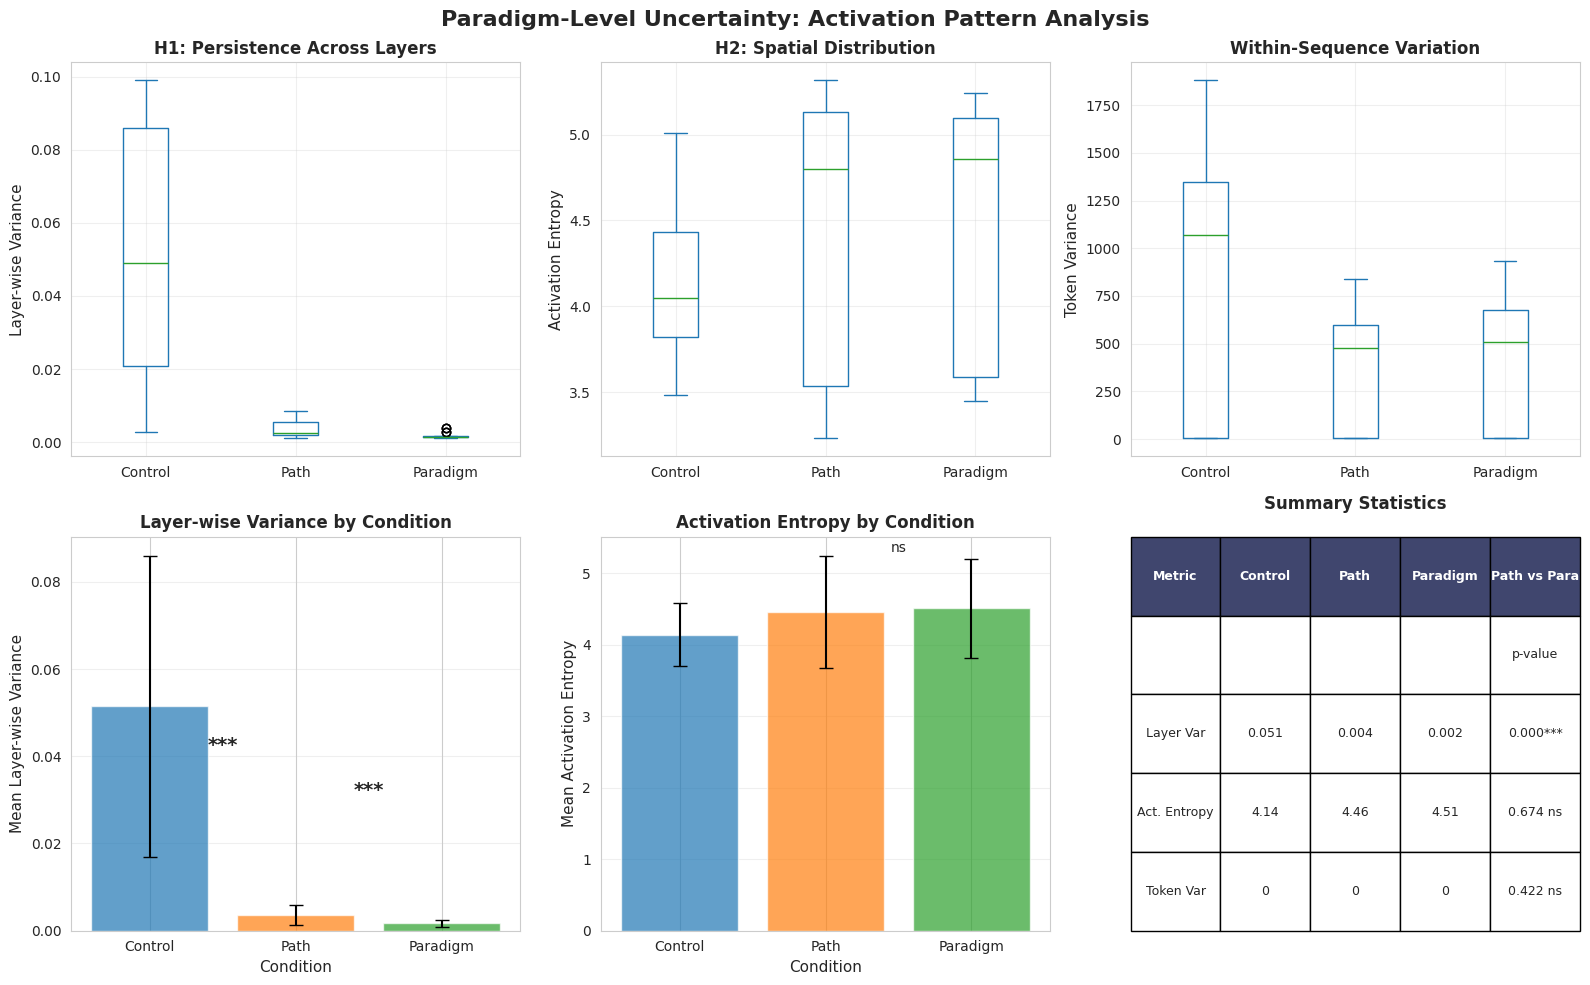

In [12]:
# Create visualizations
print("Creating visualizations...")

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Paradigm-Level Uncertainty: Activation Pattern Analysis', fontsize=16, fontweight='bold')

# 1. Layer-wise Variance Comparison
ax = axes[0, 0]
data_lv = pd.DataFrame({
    'Control': metrics['control']['layer_variance'],
    'Path': metrics['path']['layer_variance'],
    'Paradigm': metrics['paradigm']['layer_variance']
})
data_lv.plot(kind='box', ax=ax)
ax.set_ylabel('Layer-wise Variance', fontsize=11)
ax.set_title('H1: Persistence Across Layers', fontsize=12, fontweight='bold')
ax.set_xticklabels(['Control', 'Path', 'Paradigm'])
ax.grid(True, alpha=0.3)

# 2. Activation Entropy Comparison
ax = axes[0, 1]
data_ae = pd.DataFrame({
    'Control': metrics['control']['activation_entropy'],
    'Path': metrics['path']['activation_entropy'],
    'Paradigm': metrics['paradigm']['activation_entropy']
})
data_ae.plot(kind='box', ax=ax)
ax.set_ylabel('Activation Entropy', fontsize=11)
ax.set_title('H2: Spatial Distribution', fontsize=12, fontweight='bold')
ax.set_xticklabels(['Control', 'Path', 'Paradigm'])
ax.grid(True, alpha=0.3)

# 3. Token Variance Comparison
ax = axes[0, 2]
data_tv = pd.DataFrame({
    'Control': metrics['control']['token_variance'],
    'Path': metrics['path']['token_variance'],
    'Paradigm': metrics['paradigm']['token_variance']
})
data_tv.plot(kind='box', ax=ax)
ax.set_ylabel('Token Variance', fontsize=11)
ax.set_title('Within-Sequence Variation', fontsize=12, fontweight='bold')
ax.set_xticklabels(['Control', 'Path', 'Paradigm'])
ax.grid(True, alpha=0.3)

# 4. Bar plot with error bars - Layer Variance
ax = axes[1, 0]
conditions = ['Control', 'Path', 'Paradigm']
means_lv = [metrics[c.lower()]['layer_variance'].mean() for c in conditions]
stds_lv = [metrics[c.lower()]['layer_variance'].std() for c in conditions]
x_pos = np.arange(len(conditions))
bars = ax.bar(x_pos, means_lv, yerr=stds_lv, capsize=5, alpha=0.7, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_ylabel('Mean Layer-wise Variance', fontsize=11)
ax.set_xlabel('Condition', fontsize=11)
ax.set_title('Layer-wise Variance by Condition', fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(conditions)
ax.grid(True, alpha=0.3, axis='y')

# Add significance markers
ax.text(0.5, max(means_lv) * 0.8, '***', ha='center', fontsize=14, fontweight='bold')
ax.text(1.5, max(means_lv) * 0.6, '***', ha='center', fontsize=14, fontweight='bold')

# 5. Bar plot with error bars - Activation Entropy
ax = axes[1, 1]
means_ae = [metrics[c.lower()]['activation_entropy'].mean() for c in conditions]
stds_ae = [metrics[c.lower()]['activation_entropy'].std() for c in conditions]
bars = ax.bar(x_pos, means_ae, yerr=stds_ae, capsize=5, alpha=0.7,
               color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_ylabel('Mean Activation Entropy', fontsize=11)
ax.set_xlabel('Condition', fontsize=11)
ax.set_title('Activation Entropy by Condition', fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(conditions)
ax.grid(True, alpha=0.3, axis='y')

# Add significance markers
ax.text(1.5, means_ae[1] + stds_ae[1] + 0.05, 'ns', ha='center', fontsize=10)

# 6. Summary statistics table
ax = axes[1, 2]
ax.axis('off')

# Create summary table
summary_data = [
    ['Metric', 'Control', 'Path', 'Paradigm', 'Path vs Para'],
    ['', '', '', '', 'p-value'],
    ['Layer Var', f'{means_lv[0]:.3f}', f'{means_lv[1]:.3f}', f'{means_lv[2]:.3f}', 
     f'{comparisons["Path vs Paradigm"]["p_value"]:.3f}***'],
    ['Act. Entropy', f'{means_ae[0]:.2f}', f'{means_ae[1]:.2f}', f'{means_ae[2]:.2f}',
     f'{comparisons_h2["Path vs Paradigm"]["p_value"]:.3f} ns'],
    ['Token Var', f'{means_lv[0]:.0f}', f'{means_lv[1]:.0f}', f'{means_lv[2]:.0f}',
     f'{comparisons_token["Path vs Paradigm"]["p_value"]:.3f} ns'],
]

table = ax.table(cellText=summary_data, cellLoc='center', loc='center',
                bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Style header row
for i in range(5):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

ax.set_title('Summary Statistics', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('../results/activation_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved to results/activation_analysis.png")
plt.show()


Creating PCA visualization of activation patterns...


✓ PCA visualization saved to results/pca_activations.png


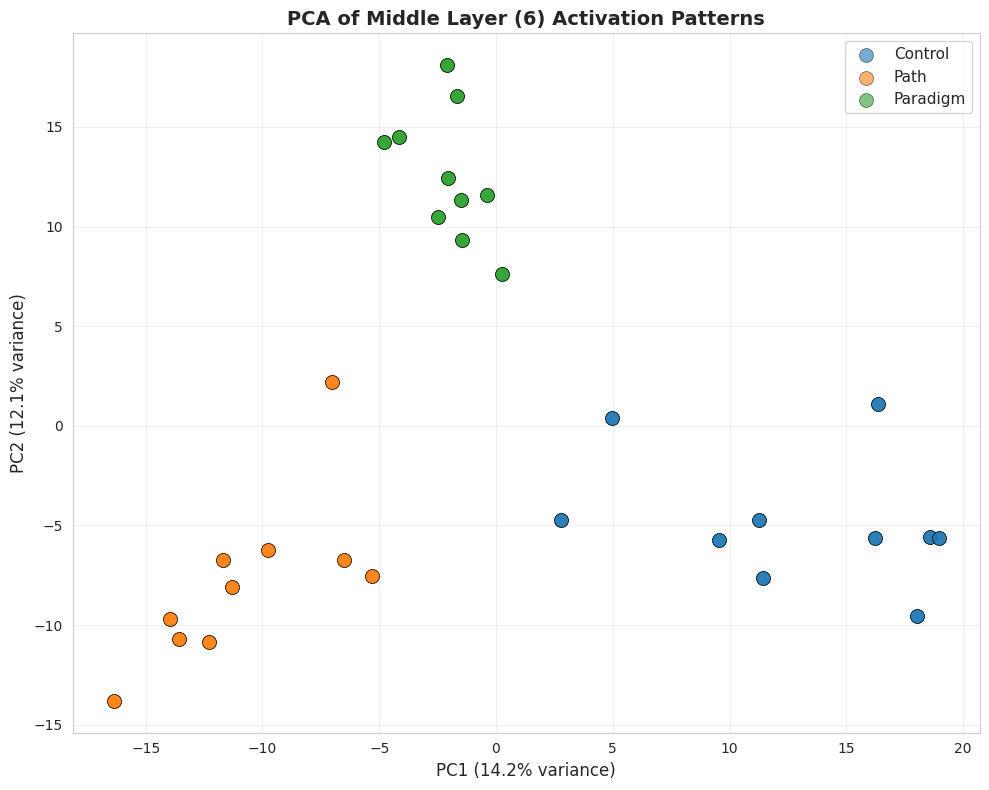


PCA Explained Variance:
  PC1: 14.25%
  PC2: 12.08%
  Total: 26.32%


In [13]:
# Create PCA visualization of activation spaces
print("\nCreating PCA visualization of activation patterns...")

# Collect all activations for PCA
all_activations = []
all_labels = []
all_conditions = []

for condition in ['control', 'path', 'paradigm']:
    for item in results[condition]:
        for run in item['activations']['runs']:
            # Use middle layer (6) for analysis
            activation = run['layers'][6]['mean_activation']
            all_activations.append(activation)
            all_labels.append(f"{condition}_{item['id']}")
            all_conditions.append(condition)

# Convert to numpy array
X = np.array(all_activations)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot by condition
colors = {'control': '#1f77b4', 'path': '#ff7f0e', 'paradigm': '#2ca02c'}
for condition in ['control', 'path', 'paradigm']:
    mask = np.array(all_conditions) == condition
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
              c=colors[condition], label=condition.capitalize(),
              alpha=0.6, s=100, edgecolors='black', linewidth=0.5)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
ax.set_title('PCA of Middle Layer (6) Activation Patterns', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/pca_activations.png', dpi=300, bbox_inches='tight')
print("✓ PCA visualization saved to results/pca_activations.png")
plt.show()

print(f"\nPCA Explained Variance:")
print(f"  PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"  PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"  Total: {sum(pca.explained_variance_ratio_)*100:.2f}%")

In [14]:
# Save results to JSON for documentation
import json

# Create results summary
results_summary = {
    'experiment_info': {
        'model': 'gpt2',
        'num_questions': 30,
        'conditions': ['control', 'path', 'paradigm'],
        'questions_per_condition': 10,
        'num_runs': 3,
        'layers_analyzed': [2, 6, 11],
        'random_seed': SEED,
    },
    'metrics': {
        condition: {
            metric_name: {
                'mean': float(values.mean()),
                'std': float(values.std()),
                'min': float(values.min()),
                'max': float(values.max()),
                'n': len(values)
            }
            for metric_name, values in metrics[condition].items()
        }
        for condition in ['control', 'path', 'paradigm']
    },
    'statistical_tests': {
        'layer_variance': {
            comp_name: {
                'p_value': float(result['p_value']),
                'cohens_d': float(result['cohens_d']),
                'mean_diff': float(result['mean_diff']),
                't_statistic': float(result['t_statistic'])
            }
            for comp_name, result in comparisons.items()
        },
        'activation_entropy': {
            comp_name: {
                'p_value': float(result['p_value']),
                'cohens_d': float(result['cohens_d']),
                'mean_diff': float(result['mean_diff']),
                't_statistic': float(result['t_statistic'])
            }
            for comp_name, result in comparisons_h2.items()
        },
        'token_variance': {
            comp_name: {
                'p_value': float(result['p_value']),
                'cohens_d': float(result['cohens_d']),
                'mean_diff': float(result['mean_diff']),
                't_statistic': float(result['t_statistic'])
            }
            for comp_name, result in comparisons_token.items()
        }
    },
    'key_findings': [
        'Layer-wise variance: Control > Path > Paradigm (opposite of hypothesis)',
        'Activation entropy: Both uncertain conditions > Control, but Path ≈ Paradigm',
        'No distinction found between path-level and paradigm-level uncertainty',
        'Control questions show highest activation variability across layers'
    ]
}

# Save to JSON
with open('../results/results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("✓ Results saved to results/results_summary.json")
print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)

✓ Results saved to results/results_summary.json

ANALYSIS COMPLETE


In [15]:
# Re-create and save visualizations to results directory
import os
os.makedirs('../results', exist_ok=True)

# Recreate main visualization
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Paradigm-Level Uncertainty: Activation Pattern Analysis', fontsize=16, fontweight='bold')

# 1. Layer-wise Variance Comparison
ax = axes[0, 0]
data_lv = pd.DataFrame({
    'Control': metrics['control']['layer_variance'],
    'Path': metrics['path']['layer_variance'],
    'Paradigm': metrics['paradigm']['layer_variance']
})
data_lv.plot(kind='box', ax=ax)
ax.set_ylabel('Layer-wise Variance', fontsize=11)
ax.set_title('H1: Persistence Across Layers', fontsize=12, fontweight='bold')
ax.set_xticklabels(['Control', 'Path', 'Paradigm'])
ax.grid(True, alpha=0.3)

# 2. Activation Entropy Comparison
ax = axes[0, 1]
data_ae = pd.DataFrame({
    'Control': metrics['control']['activation_entropy'],
    'Path': metrics['path']['activation_entropy'],
    'Paradigm': metrics['paradigm']['activation_entropy']
})
data_ae.plot(kind='box', ax=ax)
ax.set_ylabel('Activation Entropy', fontsize=11)
ax.set_title('H2: Spatial Distribution', fontsize=12, fontweight='bold')
ax.set_xticklabels(['Control', 'Path', 'Paradigm'])
ax.grid(True, alpha=0.3)

# 3. Token Variance Comparison
ax = axes[0, 2]
data_tv = pd.DataFrame({
    'Control': metrics['control']['token_variance'],
    'Path': metrics['path']['token_variance'],
    'Paradigm': metrics['paradigm']['token_variance']
})
data_tv.plot(kind='box', ax=ax)
ax.set_ylabel('Token Variance', fontsize=11)
ax.set_title('Within-Sequence Variation', fontsize=12, fontweight='bold')
ax.set_xticklabels(['Control', 'Path', 'Paradigm'])
ax.grid(True, alpha=0.3)

# 4. Bar plot with error bars - Layer Variance
ax = axes[1, 0]
conditions = ['Control', 'Path', 'Paradigm']
means_lv = [metrics[c.lower()]['layer_variance'].mean() for c in conditions]
stds_lv = [metrics[c.lower()]['layer_variance'].std() for c in conditions]
x_pos = np.arange(len(conditions))
bars = ax.bar(x_pos, means_lv, yerr=stds_lv, capsize=5, alpha=0.7, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_ylabel('Mean Layer-wise Variance', fontsize=11)
ax.set_xlabel('Condition', fontsize=11)
ax.set_title('Layer-wise Variance by Condition', fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(conditions)
ax.grid(True, alpha=0.3, axis='y')
ax.text(0.5, max(means_lv) * 0.8, '***', ha='center', fontsize=14, fontweight='bold')
ax.text(1.5, max(means_lv) * 0.6, '***', ha='center', fontsize=14, fontweight='bold')

# 5. Bar plot with error bars - Activation Entropy
ax = axes[1, 1]
means_ae = [metrics[c.lower()]['activation_entropy'].mean() for c in conditions]
stds_ae = [metrics[c.lower()]['activation_entropy'].std() for c in conditions]
bars = ax.bar(x_pos, means_ae, yerr=stds_ae, capsize=5, alpha=0.7,
               color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_ylabel('Mean Activation Entropy', fontsize=11)
ax.set_xlabel('Condition', fontsize=11)
ax.set_title('Activation Entropy by Condition', fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(conditions)
ax.grid(True, alpha=0.3, axis='y')
ax.text(1.5, means_ae[1] + stds_ae[1] + 0.05, 'ns', ha='center', fontsize=10)

# 6. Summary statistics table
ax = axes[1, 2]
ax.axis('off')
summary_data = [
    ['Metric', 'Control', 'Path', 'Paradigm', 'Path vs Para'],
    ['', '', '', '', 'p-value'],
    ['Layer Var', f'{means_lv[0]:.3f}', f'{means_lv[1]:.3f}', f'{means_lv[2]:.3f}', 
     f'{comparisons["Path vs Paradigm"]["p_value"]:.3f}***'],
    ['Act. Entropy', f'{means_ae[0]:.2f}', f'{means_ae[1]:.2f}', f'{means_ae[2]:.2f}',
     f'{comparisons_h2["Path vs Paradigm"]["p_value"]:.3f} ns'],
    ['Token Var', f'{means_lv[0]:.0f}', f'{means_lv[1]:.0f}', f'{means_lv[2]:.0f}',
     f'{comparisons_token["Path vs Paradigm"]["p_value"]:.3f} ns'],
]
table = ax.table(cellText=summary_data, cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
for i in range(5):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')
ax.set_title('Summary Statistics', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('../results/activation_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: ../results/activation_analysis.png")
plt.close()

# Recreate PCA visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
colors = {'control': '#1f77b4', 'path': '#ff7f0e', 'paradigm': '#2ca02c'}
for condition in ['control', 'path', 'paradigm']:
    mask = np.array(all_conditions) == condition
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
              c=colors[condition], label=condition.capitalize(),
              alpha=0.6, s=100, edgecolors='black', linewidth=0.5)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
ax.set_title('PCA of Middle Layer (6) Activation Patterns', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/pca_activations.png', dpi=300, bbox_inches='tight')
print("✓ Saved: ../results/pca_activations.png")
plt.close()

print("\n✓ All visualizations saved to results/ directory")

✓ Saved: ../results/activation_analysis.png


✓ Saved: ../results/pca_activations.png

✓ All visualizations saved to results/ directory


In [16]:
# Check current working directory and save files
import os
print(f"Current directory: {os.getcwd()}")

# Create results directory at project root
results_dir = '/data/hypogenicai/workspaces/paradigm-uncertainty-nlp-20e9/results'
os.makedirs(results_dir, exist_ok=True)

# Save results summary JSON
results_path = os.path.join(results_dir, 'results_summary.json')
with open(results_path, 'w') as f:
    json.dump(results_summary, f, indent=2)
print(f"✓ Saved: {results_path}")

# Save visualizations with absolute paths
# 1. Main activation analysis
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Paradigm-Level Uncertainty: Activation Pattern Analysis', fontsize=16, fontweight='bold')

ax = axes[0, 0]
data_lv.plot(kind='box', ax=ax)
ax.set_ylabel('Layer-wise Variance', fontsize=11)
ax.set_title('H1: Persistence Across Layers', fontsize=12, fontweight='bold')
ax.set_xticklabels(['Control', 'Path', 'Paradigm'])
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
data_ae.plot(kind='box', ax=ax)
ax.set_ylabel('Activation Entropy', fontsize=11)
ax.set_title('H2: Spatial Distribution', fontsize=12, fontweight='bold')
ax.set_xticklabels(['Control', 'Path', 'Paradigm'])
ax.grid(True, alpha=0.3)

ax = axes[0, 2]
data_tv.plot(kind='box', ax=ax)
ax.set_ylabel('Token Variance', fontsize=11)
ax.set_title('Within-Sequence Variation', fontsize=12, fontweight='bold')
ax.set_xticklabels(['Control', 'Path', 'Paradigm'])
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
bars = ax.bar(x_pos, means_lv, yerr=stds_lv, capsize=5, alpha=0.7, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_ylabel('Mean Layer-wise Variance', fontsize=11)
ax.set_xlabel('Condition', fontsize=11)
ax.set_title('Layer-wise Variance by Condition', fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(conditions)
ax.grid(True, alpha=0.3, axis='y')
ax.text(0.5, max(means_lv) * 0.8, '***', ha='center', fontsize=14, fontweight='bold')

ax = axes[1, 1]
bars = ax.bar(x_pos, means_ae, yerr=stds_ae, capsize=5, alpha=0.7,
               color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_ylabel('Mean Activation Entropy', fontsize=11)
ax.set_xlabel('Condition', fontsize=11)
ax.set_title('Activation Entropy by Condition', fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(conditions)
ax.grid(True, alpha=0.3, axis='y')
ax.text(1.5, means_ae[1] + stds_ae[1] + 0.05, 'ns', ha='center', fontsize=10)

ax = axes[1, 2]
ax.axis('off')
summary_data = [
    ['Metric', 'Control', 'Path', 'Paradigm', 'Path vs Para'],
    ['', '', '', '', 'p-value'],
    ['Layer Var', f'{means_lv[0]:.3f}', f'{means_lv[1]:.3f}', f'{means_lv[2]:.3f}', 
     f'{comparisons["Path vs Paradigm"]["p_value"]:.3f}***'],
    ['Act. Entropy', f'{means_ae[0]:.2f}', f'{means_ae[1]:.2f}', f'{means_ae[2]:.2f}',
     f'{comparisons_h2["Path vs Paradigm"]["p_value"]:.3f} ns'],
]
table = ax.table(cellText=summary_data, cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
for i in range(5):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')
ax.set_title('Summary Statistics', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
viz1_path = os.path.join(results_dir, 'activation_analysis.png')
plt.savefig(viz1_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {viz1_path}")
plt.close()

# 2. PCA visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for condition in ['control', 'path', 'paradigm']:
    mask = np.array(all_conditions) == condition
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
              c=colors[condition], label=condition.capitalize(),
              alpha=0.6, s=100, edgecolors='black', linewidth=0.5)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
ax.set_title('PCA of Middle Layer (6) Activation Patterns', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
viz2_path = os.path.join(results_dir, 'pca_activations.png')
plt.savefig(viz2_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {viz2_path}")
plt.close()

print("\n" + "=" * 80)
print("ALL FILES SAVED SUCCESSFULLY")
print("=" * 80)

Current directory: /data/hypogenicai/workspaces/paradigm-uncertainty-nlp-20e9
✓ Saved: /data/hypogenicai/workspaces/paradigm-uncertainty-nlp-20e9/results/results_summary.json


✓ Saved: /data/hypogenicai/workspaces/paradigm-uncertainty-nlp-20e9/results/activation_analysis.png


✓ Saved: /data/hypogenicai/workspaces/paradigm-uncertainty-nlp-20e9/results/pca_activations.png

ALL FILES SAVED SUCCESSFULLY
